In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Mpl = 1.2209e19
gstar = 90.0
gstar_s = 90.0

# Today
T0_K = 2.7255
eV_per_K = 8.617333262e-5  # eV/K
GeV_per_eV = 1.0e-9
T0 = T0_K * eV_per_K * GeV_per_eV     # GeV
gstar_s0 = 3.91            # today’s entropy d.o.f.
rho_c_over_h2 = 1.05375e-5 # GeV/cm^3
s0 = 2970 #(2.0*np.pi**2/45.0) * gstar_s0 * T0**3  # today's entropy density [GeV^3]

# ----------------------------
# Default parameters
# ----------------------------
m = 100.0                  # DM mass [GeV]
g_chi = 2.0                # internal dof for DM
sigmav_cm3_s = 2.0e-26     # <sigmav> in cm^3/s (thermal relic)
x_initial = 1.0e-3
x_final = 1.0e3            # integrate to late times (nonrel.)
num_points = 2000

# ----------------------------
# Unit conversions
# ----------------------------
cm_to_GeV_inv = 5.0677307e13
s_to_GeV_inv  = 1.5192674e24
cm3_s_to_GeVm2 = (cm_to_GeV_inv**3) / s_to_GeV_inv   # cm^3/s -> GeV^-2
sigmav = sigmav_cm3_s * cm3_s_to_GeVm2               # GeV^-2

def H_rad(T):
    """Hubble in radiation domination: H = sqrt(8π^3 g*/90) * T^2 / Mpl  [GeV]."""
    return np.sqrt(8.0*np.pi**3/90.0 * gstar) * T**2 / Mpl

def n_eq_MB(T):
    """MB equilibrium number density for a nonrel. species."""
    return g_chi * (m*T/(2.0*np.pi))**1.5 * np.exp(-m/T)

def s_entropy(T):
    """Entropy density: s = (2π^2/45) g*_s T^3."""
    return (2.0*np.pi**2/45.0) * gstar_s * T**3 #gstar_s = total entropy d.o.f. for plasma

def x_to_T(x):
    return m / x

def boltz_rhs(x, n):
    """
    dn/dx = -3n/x - (⟨sigma v⟩/(H x)) * (n^2 - n_eq^2)
    where dx/dt = H x  in radiation domination (since T ~ 1/a).
    """
    T = x_to_T(x)
    H = H_rad(T)
    neq = n_eq_MB(T)
    return -3.0*n/x - (sigmav/(H*x)) * (n*n - neq*neq)

def bolz_rhs_logspace(x, logn):
    """RHS in log space: d(log n)/dx = (1/n) dn/dx."""
    n = np.exp(logn)
    return boltz_rhs(x, n) / n

In [ ]:
print(s0)
print(rho_c_over_h2)
print(s0 /rho_c_over_h2)

2970
1.05375e-05
281850533.8078292


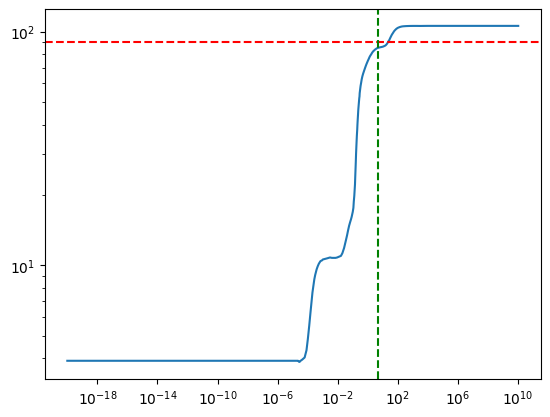

In [13]:
path = "/Users/charlottemyers/projects/ctp/heffBW.dat"
data = np.loadtxt(path)
T_data = data[:,0]
g_eff = data[:,1]

#plot
plt.plot(T_data, g_eff)
plt.xscale('log')
plt.yscale('log')
plt.axhline(y=gstar, color='r', linestyle='--')
# expected x of freeze out
plt.axvline(x=m/20, color='g', linestyle='--')

In [ ]:
# Initial condition: start in equilibrium
n_init = n_eq_MB(x_to_T(x_initial))

# Integrate
# ----------------------------
xs = np.geomspace(x_initial, x_final, num_points)

m  = 100.0
sigmav = 2.0e-26 * cm3_s_to_GeVm2


def evolve(M, sigmav, x_initial, x_final, n_init, xs):
    """Evolve the Boltzmann equation for given parameters."""
    sol = solve_ivp(
        fun=lambda xx, nn: boltz_rhs(xx, nn),
        t_span=(x_initial, x_final),
        y0=[n_init],
        t_eval=xs,
        rtol=1e-7,
        atol=1e-12,
        method="Radau"
    )
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")
    return sol


sol = solve_ivp(
    fun=lambda xx, nn: boltz_rhs(xx, nn),
    t_span=(x_initial, x_final),
    y0=[n_init],
    t_eval=xs,
    rtol=1e-7,
    atol=1e-12,
    method="Radau"
)

if not sol.success:
    raise RuntimeError(f"Integration failed: {sol.message}")


x_arr = sol.t
n_arr = sol.y[0]
T_arr = x_to_T(x_arr)
neq_arr = n_eq_MB(T_arr)

# Derived: yield Y = n/s and relic abundance omega*h^2 ≈ 2.742e8 (m/GeV) Y0
s_arr = s_entropy(T_arr)
Y_arr = n_arr / s_arr

Y0 = Y_arr[-1] # asymptotic (late-time) Y
Omega_h2 = 2.742e8 * (m) * Y0  # dimensionless

print(f"Relic abundance (approx): Ωχ h^2 ≈ {Omega_h2:.3f}")
print(f"Asymptotic yield Y0 ≈ {Y0:.3e}")


Relic abundance (approx): Ωχ h^2 ≈ 0.115
Asymptotic yield Y0 ≈ 4.201e-12


<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
/var/folders/gh/dkmyc07x05s0k1vgjj6s10hw0000gn/T/ipykernel_69587/812785437.py:24: SyntaxWarning: invalid escape sequence '\c'
  plt.text(0.8, 0.8, f'm = {m}' + '$_{\chi}$ GeV', transform=plt.gca().transAxes)


Text(0.8, 0.8, 'm = 100.0$_{\\chi}$ GeV')

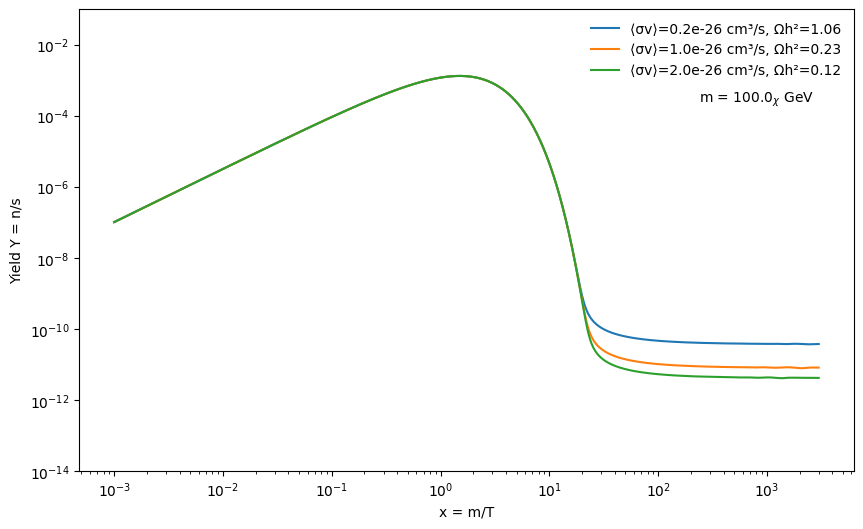

In [7]:
# loop over several values of cross section to see effect on relic abundance
m = 100.0  # GeV
sigmav_list = [0.2, 1.0, 2.0]  # in units of 1e-26 cm^3/s
colors = ['C0', 'C1', 'C2']
plt.figure(figsize=(10, 6))
for sv, color in zip(sigmav_list, colors):
    sigmav = sv * 1.0e-26 * cm3_s_to_GeVm2
    sol = evolve(m, sigmav, x_initial, x_final, n_init, xs)
    n_arr = sol.y[0]
    s_arr = s_entropy(x_to_T(sol.t))
    Y_arr = n_arr / s_arr
    Y0 = Y_arr[-1]
    rho_DM = m * s0 * Y0  # GeV/cm^3
    Omega_h2 = rho_DM / rho_c_over_h2
    plt.plot(sol.t, Y_arr, label=f'⟨σv⟩={sv:.1f}e-26 cm³/s, Ωh²={Omega_h2:.2f}', color=color)

plt.ylim(1e-14, 1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x = m/T')
plt.ylabel('Yield Y = n/s')
plt.legend(frameon = False)
# text annotation of mass
plt.text(0.8, 0.8, f'm = {m}' + '$_{\chi}$ GeV', transform=plt.gca().transAxes)


# # plot equilibrium yield for reference
# plt.plot(x_arr, neq_arr/s_arr, 'k--', label='Equilibrium', alpha=0.5)
# plt.title('Evolution of DM Yield Y = n/s')
# plt.ylabel('Yield Y = n/s')

Text(0.8, 0.8, '⟨σv⟩ = 2.0e-26 cm³/s')

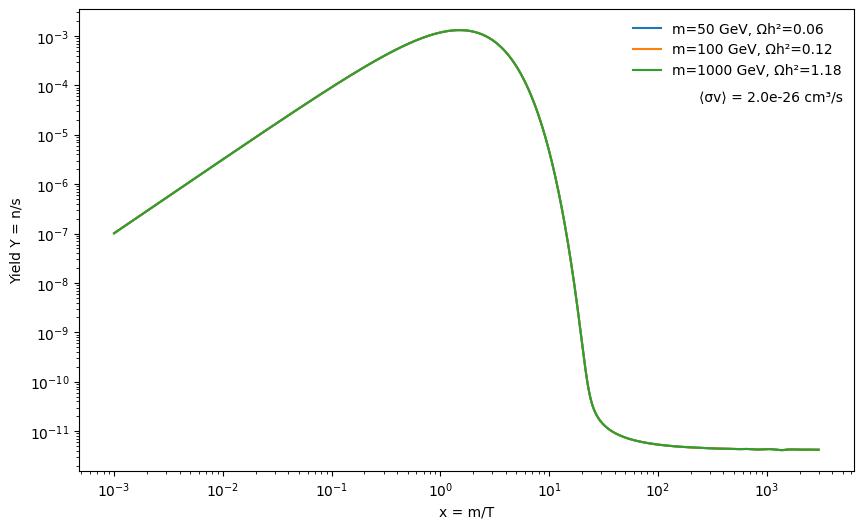

In [ ]:
# loop over several values of mass to see effect on relic abundance
m_list = [50.0, 100.0, 1000.0]  # GeV
colors = ['C0', 'C1', 'C2']
plt.figure(figsize=(10, 6))
for mm, color in zip(m_list, colors):
    n_init = n_eq_MB(x_to_T(x_initial))
    sol = evolve(mm, sigmav, x_initial, x_final, n_init, xs)
    n_arr = sol.y[0]
    s_arr = s_entropy(x_to_T(sol.t))
    Y_arr = n_arr / s_arr
    Y0 = Y_arr[-1]
    rho_DM = mm * Y0 * s0  # GeV/cm^3
    Omega_h2 = rho_DM /rho_c_over_h2 # dimensionless
    plt.plot(sol.t, Y_arr, label=f'm={mm:.0f} GeV, Ωh²={Omega_h2:.2f}', color=color)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('x = m/T')
#plt.xlim(1e-3, 1e3)
plt.ylabel('Yield Y = n/s')
plt.legend(frameon = False)

# add text annotation of cross section
plt.text(0.8, 0.8, f'⟨σv⟩ = 2.0e-26 cm³/s', transform=plt.gca().transAxes)

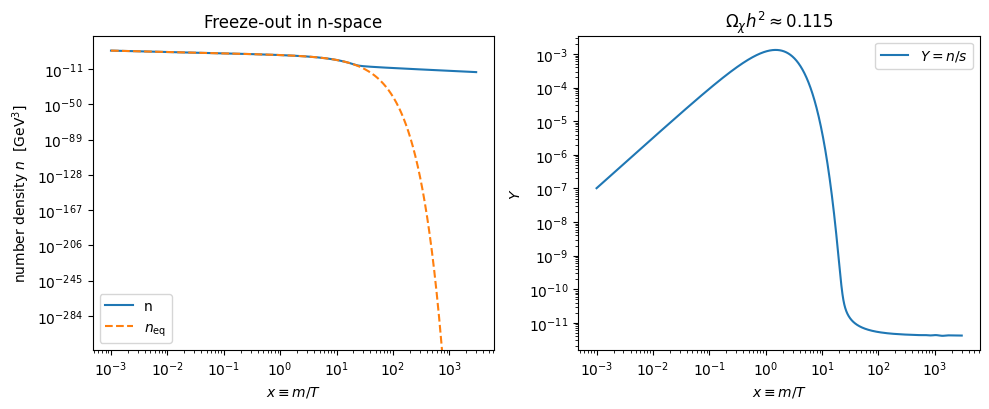

In [3]:
# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 4.2))
ax[0].loglog(x_arr, n_arr, label="n")
ax[0].loglog(x_arr, neq_arr, ls="--", label=r"$n_{\rm eq}$")
ax[0].set_xlabel(r"$x \equiv m/T$")
ax[0].set_ylabel(r"number density $n$  [GeV$^3$]")
ax[0].set_title("Freeze-out in n-space")
ax[0].legend()

ax[1].loglog(x_arr, Y_arr, label=r"$Y=n/s$")
ax[1].set_xlabel(r"$x \equiv m/T$")
ax[1].set_ylabel(r"$Y$")
ax[1].set_title(fr"$\Omega_\chi h^2 \approx {Omega_h2:.3f}$")
ax[1].legend()

plt.tight_layout()
plt.show()